In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
# сгенерируем датасет с определением сколько тратит в месяц человек в зависимости от возраста, з/п,
#ежемесячных обязательств (вклады или ипотека, кредиты)

n_samples = 1000

age = np.random.choice(50, n_samples) + 10
salary = np.random.choice(50000, n_samples) + 10000
liability = np.random.choice(15000, n_samples) + 750

expenses = (salary - liability)*(1 - age/100)

data = pd.DataFrame({'age': age, 'salary': salary, 'liability' : liability, 'expenses': expenses})
data.head(5)

,age,salary,liability,expenses
0,25,45709,9645,27048.00
1,37,28090,15416,7984.62
2,30,25190,2322,16007.60
3,38,14950,6826,5036.88
4,59,40373,7680,13404.13


In [8]:
# сразу уберем строки, где возраст меньше 18 лет (т.е. оставляем только совершеннолетних - людей, 
#у которых есть постоянная работа)

#сначала хотела убрать тех, у кого траты отрицательные, но ведь такое возможно

data = data[data['age'] > 18]
data.head()

,age,salary,liability,expenses
0,25,45709,9645,27048.00
1,37,28090,15416,7984.62
2,30,25190,2322,16007.60
3,38,14950,6826,5036.88
4,59,40373,7680,13404.13


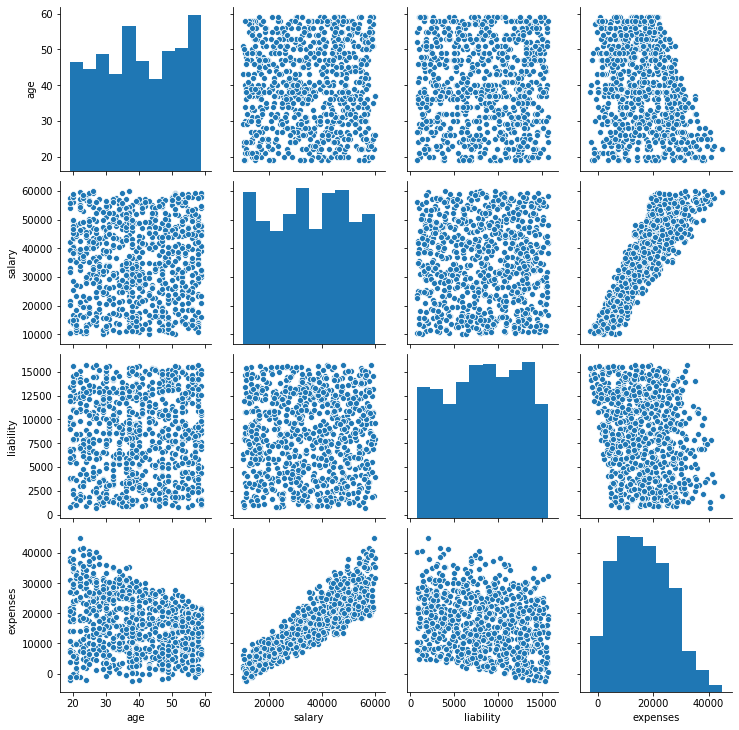

In [9]:
# посмотрим на попарные графики
sns.pairplot(data)

In [15]:
# применим к датасету polynomical features

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)

newdata = pd.DataFrame(poly.fit_transform(data))

In [16]:
newdata.columns = ['age', 'salary', 'liability', 'expenses', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']
newdata.head()

,age,salary,liability,expenses,f1,f2,f3,f4,f5,f6
0,25.0,45709.0,9645.0,27048.00,1142725.0,241125.0,676200.00,440863305.0,1.236337e+09,2.608780e+08
1,37.0,28090.0,15416.0,7984.62,1039330.0,570392.0,295430.94,433035440.0,2.242880e+08,1.230909e+08
2,30.0,25190.0,2322.0,16007.60,755700.0,69660.0,480228.00,58491180.0,4.032314e+08,3.716965e+07
3,38.0,14950.0,6826.0,5036.88,568100.0,259388.0,191401.44,102048700.0,7.530136e+07,3.438174e+07
4,59.0,40373.0,7680.0,13404.13,2382007.0,453120.0,790843.67,310064640.0,5.411649e+08,1.029437e+08


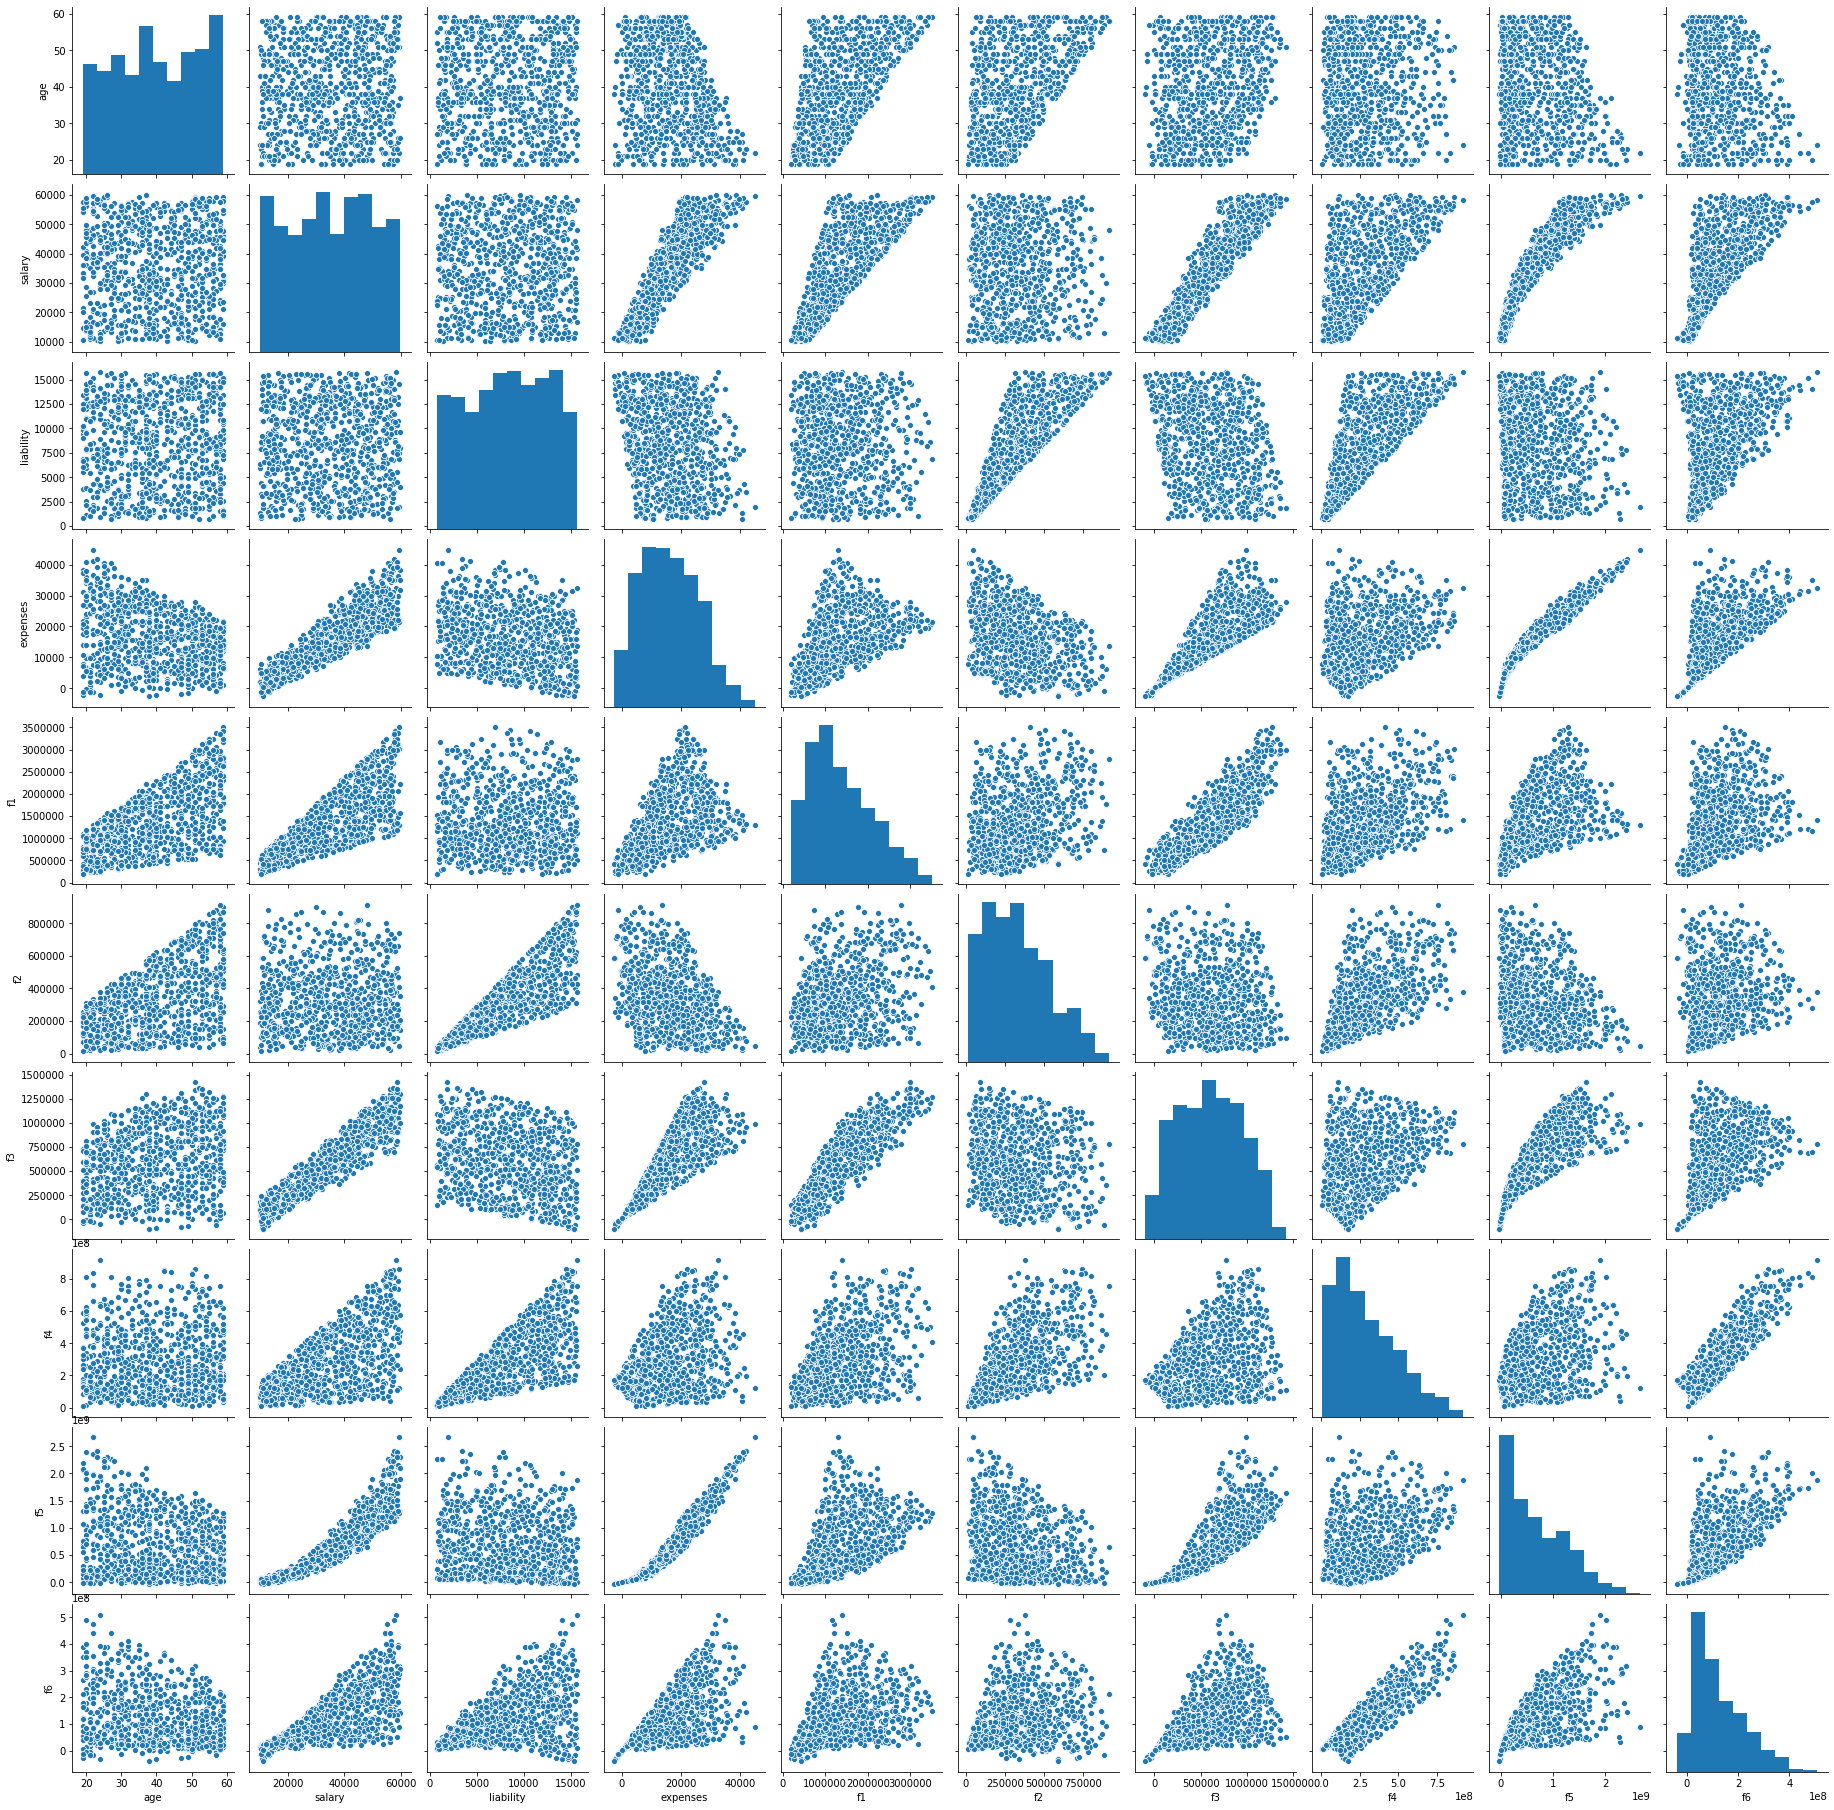

In [17]:
# посмотрим на парные графики еще раз
sns.pairplot(newdata)

In [18]:
# видно, что целевая переменная expenses имеет зависимость, близкую к линейной, с фичей f5, 
# подбираем коэфициент

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# нормализуем данные
X = newdata['f5'].values.reshape(-1,1)
y = newdata['expenses']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bais: {}'.format(reg.intercept_))

pred_values = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [1.64344601e-05]
Bais: 4791.233266155674
Error: 1950.4876212879253


In [19]:
# ошибка равна 1950, 
#сравним ее со средним значением ошибки

mean_absolute_error(pred_values, y)/y.mean()

0.12081788987976176

выходит около 12% - неплохо

In [22]:
# попробую добавить остальные фичи, имеющие почти линейную зависимость

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression


X = newdata[['salary', 'f3', 'f5']]
y = newdata['expenses']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bais: {}'.format(reg.intercept_))

pred_values2 = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values2, y)))

Weights: [-7.45891384e-02  2.81838834e-03  1.67392885e-05]
Bais: 5501.71041047898
Error: 1930.1172027602445


In [23]:
# ошибка равна 1930, 
#сравним ее со средним значением ошибки

mean_absolute_error(pred_values2, y)/y.mean()

0.11955609721026668

модель немного улучшилась

In [24]:
# попробую оставить только salary и f5, имеющие почти линейную зависимость

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

X = newdata[['salary', 'f5']]
y = newdata['expenses']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bais: {}'.format(reg.intercept_))

pred_values3 = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values3, y)))

Weights: [-8.26465708e-04  1.64534694e-05]
Bais: 4807.102967406416
Error: 1950.440720314381


Нет, ошибка такая же, как и в первой модели.
Значит, оставляем второй вариант (с salary, f3 и f5)